In [1]:
# !pip install visdom

## Imports

In [2]:
from __future__ import print_function
from __future__ import division

import visdom
import torch
import torchvision

import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
import time
import os
import copy

In [3]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.6.0+cu101
Torchvision Version:  0.7.0+cu101


## Set Seeds & Global Variables

In [4]:
torch.manual_seed(0)
np.random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

feature_extract = True

num_epochs = 100

In [5]:
# Detect if we have a GPU available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = (torch.device('cuda:0') if torch.cuda.is_available()
    else torch.device('gpu'))
print(f"Training on device {device}.")
print(f"# cuda device: {torch.cuda.device_count()}")
print(f"Id current device: {torch.cuda.current_device()}")

Training on device cuda:0.
# cuda device: 1
Id current device: 0


In [6]:
'''vis = visdom.Visdom()
vis.text('Hello, world!')
vis.image(np.ones((3, 10, 10)))'''

"vis = visdom.Visdom()\nvis.text('Hello, world!')\nvis.image(np.ones((3, 10, 10)))"

## Functions

In [7]:
def load_train_val_sets(batch_size = 64, data_path = '/content/cifar-10-batches-py'):

    class_objects = "airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck".split(",")

    class_indeces = range(0, 10)
    item_pairs = zip(class_indeces, class_objects)
    class_names = dict(item_pairs)

    class_indeces = range(0, 10)
    item_pairs_reverse = zip(class_objects, class_indeces)
    class_names_reverse = dict(item_pairs_reverse)

    tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=True,
    transform=transforms.ToTensor())

    imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
    mean_by_channels = imgs.view(3, -1).mean(dim=1)
    std_by_channels = imgs.view(3, -1).std(dim=1)

    transformed_cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
        transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=mean_by_channels, std=std_by_channels)
            ]
        )
    )

    transformed_cifar10_val = datasets.CIFAR10(data_path, train=False, download=True,
        transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=mean_by_channels, std=std_by_channels)
            ]
        )
    )

    train_loader = torch.utils.data.DataLoader(
        transformed_cifar10, batch_size = batch_size, shuffle = True
    )

    val_loader = torch.utils.data.DataLoader(
        transformed_cifar10_val, batch_size = batch_size, shuffle = False
    )
    return train_loader, val_loader

In [8]:
def convnet_validate(model, train_loader, val_loader):
    """
    Validate model's performance calculating Accuracy scores for both training
    set and validation set, where input model's is made of at least one convolution layer.

    Parameters:
    -----------
    :model: either nn.Sequential or subclass from nn.Module
    :train_loader: either nn.DataLoader or nn.DataSet instances collecting data examples employed for training the model
    :val_loader: either nn.DataLoader or nn.DataSet instances collecting data examples constituting validation set

    Returns:
    --------
    :result_str: str Python object for later dispalying containing as a message 
        the Accuracy scores calculated for both train and val set passed independently to model instance 
    """

    # switch to evaluate mode
    model.eval()

    result_str = ""

    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)

                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim = 1)
                
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
                pass
        result_str += "Accuracy {}: {:.5f} ".format(name, correct / total)
    
    return result_str

In [9]:
def batched_convnet_training_loop(model, loss_fn, optimizer, train_loader, val_loader, n_epochs = 10):
    """
    More Advanced training loop for brief tests exploiting Batch Strategy to let training be more stable and smooth, 
    where model's arch is represented by a ConvNet.
    
    Parameters:
    -----------
    :model: either nn.Sequential or subclass from nn.Module
    :loss_fn: loss function pytorch's instance, expressing a particular loss function shape to be minimized by means of a particular optimization strategy
    :optimizer: optimizer pytorch's instance representing the selected optimization strategy to be followed to fit the model's arch to the train data
    :train_loader: either nn.DataLoader or nn.DataSet instances collecting data examples employed for training the model
    :val_loader: either nn.DataLoader or nn.DataSet instances collecting data examples constituting validation set

    Returns:
    --------
    None 
    """

    # Initialize the visualization environment
    # vis = Visualizations()

    # Training loop
    loss_values = []
    for epoch in range(1, n_epochs + 1):

        # switch to train mode
        model.train()
        
        for step, (imgs, labels) in enumerate(train_loader):
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss_values.append(loss.item())
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Visualization data
            """if step % 10 == 0:
                vis.plot_loss(np.mean(loss_values), step)
                loss_values.clear()"""
            pass

        result_validate_str = convnet_validate(model, train_loader, val_loader)
        
        epoch_msg = "%s Epoch: %d, Trainin Loss: %.5f %s" \
              % (str(datetime.datetime.now()),
                 epoch, float(loss),
                 result_validate_str.strip()
                 )
        print(epoch_msg)
        pass

In [10]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    history = dict(zip("train_acc,val_acc,train_loss,val_loss".split(","), [train_acc_history, val_acc_history, train_loss_history, val_loss_history]))
    return model, history

## Classes

In [11]:
class Visualizations:
    def __init__(self, env_name=None):
        if env_name is None:
            env_name = str(datetime.datetime.now().strftime("%d-%m %Hh%M"))
        self.env_name = env_name
        self.vis = visdom.Visdom(env=self.env_name)
        self.loss_win = None

    def plot_loss(self, loss, step):
        self.loss_win = self.vis.line(
            [loss],
            [step],
            win=self.loss_win,
            update='append' if self.loss_win else None,
            opts=dict(
                xlabel='Step',
                ylabel='Loss',
                title='Loss (mean per 10 steps)',
            )
        )

In [12]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [13]:
class Net(nn.Module):
    def __init__(self, num_classes = 2):
        super().__init__()
        
        # First Conv + Act + Pool full block
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.act1 = torch.sin # nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        
        # Second Conv + Act + Pool full block
        self.conv2 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
        self.act2 = torch.sin # nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)

        # Fully Connected layers on top NN Arch.
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = torch.sin # nn.Tanh()
        self.fc2 = nn.Linear(32, num_classes)
        pass

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out
    pass

class NetSiren(nn.Module):
    def __init__(self, num_classes = 2):
        super().__init__()
        
        self.siren = Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)

        # Fully Connected layers on top NN Arch.
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, num_classes)
        pass

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out
    pass

## Load Data & Build Model

In [14]:
siren = Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
numel_list = [p.numel() for p in siren.parameters() if p.requires_grad == True]
print(siren)
print(sum(numel_list), numel_list)

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)
198915 [512, 256, 65536, 256, 65536, 256, 65536, 256, 768, 3]


In [15]:
# build a model
model = Net(num_classes = 10)
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
print(model)
print(sum(numel_list), numel_list)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
18354 [432, 16, 1152, 8, 16384, 32, 320, 10]


In [16]:
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

criterion = nn.CrossEntropyLoss()

In [17]:
train_loader, val_loader = load_train_val_sets()

Files already downloaded and verified
Files already downloaded and verified


In [18]:
model = model.to(device)
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 conv1.weight
	 conv1.bias
	 conv2.weight
	 conv2.bias
	 fc1.weight
	 fc1.bias
	 fc2.weight
	 fc2.bias


## Run Training Phase

In [19]:
# batched_convnet_training_loop(model.to(device), criterion, optimizer, train_loader, val_loader, n_epochs = 10)
dataloaders = dict(zip(['train', 'val'], [train_loader, val_loader]))
model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs, is_inception=False)

Epoch 0/99
----------
train Loss: 2.2622 Acc: 0.1380
val Loss: 2.2080 Acc: 0.1948

Epoch 1/99
----------
train Loss: 2.1559 Acc: 0.2404
val Loss: 2.1089 Acc: 0.2657

Epoch 2/99
----------
train Loss: 2.0807 Acc: 0.2690
val Loss: 2.0481 Acc: 0.2785

Epoch 3/99
----------
train Loss: 2.0264 Acc: 0.2852
val Loss: 1.9977 Acc: 0.3001

Epoch 4/99
----------
train Loss: 1.9803 Acc: 0.3013
val Loss: 1.9560 Acc: 0.3147

Epoch 5/99
----------
train Loss: 1.9425 Acc: 0.3144
val Loss: 1.9216 Acc: 0.3273

Epoch 6/99
----------
train Loss: 1.9108 Acc: 0.3259
val Loss: 1.8918 Acc: 0.3421

Epoch 7/99
----------
train Loss: 1.8828 Acc: 0.3378
val Loss: 1.8648 Acc: 0.3518

Epoch 8/99
----------
train Loss: 1.8571 Acc: 0.3495
val Loss: 1.8394 Acc: 0.3619

Epoch 9/99
----------
train Loss: 1.8325 Acc: 0.3590
val Loss: 1.8150 Acc: 0.3695

Epoch 10/99
----------
train Loss: 1.8078 Acc: 0.3678
val Loss: 1.7889 Acc: 0.3753

Epoch 11/99
----------
train Loss: 1.7815 Acc: 0.3780
val Loss: 1.7611 Acc: 0.3882

Ep

## Show graphics

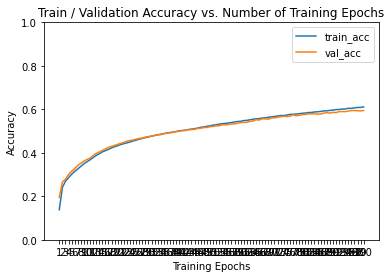

In [20]:
# Plot the training curves of train / validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
train_acc_h = []
val_acc_h = []

train_acc_h = [h.cpu().numpy() for h in history['train_acc']]
val_acc_h = [h.cpu().numpy() for h in history['val_acc']]

plt.title("Train / Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1), train_acc_h, label="train_acc")
plt.plot(range(1,num_epochs+1), val_acc_h, label="val_acc")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

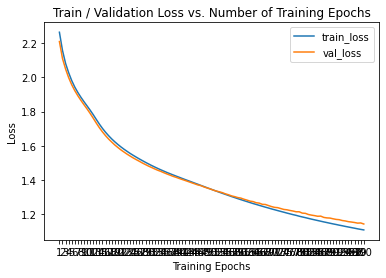

In [23]:
# Plot the training curves of train validation loss vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
train_loss_h = []
val_loss_h = []

train_loss_h = [h for h in history['train_loss']]
val_loss_h = [h for h in history['val_loss']]

plt.title("Train / Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,num_epochs+1), train_loss_h, label="train_loss")
plt.plot(range(1,num_epochs+1), val_loss_h, label="val_loss")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## References

- Pytorch Reference's Manual:
 - [torch.nn module](https://pytorch.org/docs/stable/nn.html)
 - [TensorBoard Support](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html)
 - [Train Example](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#model-training-and-validation-code)

- Initialization Topic (Papers):
  - [Understanding the difficulty of training deep feedforward neural networks](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) by X. Glorot & Y.Bengio, which lead to default Pytorch's weights initialization knwon as *Xavier initialization* algorithm or scheme
 -  [Fixup Initialization: Residual Learning Without Normalization](https://arxiv.org/abs/1901.09321) by Hongyi Zhang, Yann N. Dauphin, Tengyu Ma, whose works allows to *get rid off batch normalization layers* with a given particular NN Arch, to still be able to train a NN arch with meaningful and confident results or performance.

- Activation Functions (Papers):
  - [Deep Learning using Rectified Linear Units (ReLU)](https://arxiv.org/pdf/1803.08375.pdf)

- Datasets:
  - [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)

- Regularization techniques (Papers):
  - [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shif](https://arxiv.org/abs/1502.03167)
  - [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)

- Archs Types (Papers):
  - [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
  - [Densely Connected Convolutional Networks](https://arxiv.org/abs/1608.06993)
  - [Highway Networks
](https://arxiv.org/pdf/1505.00387.pdf)
  - [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)

- Some Third Party useful Tutorials:
 - [Imagenet example](https://github.com/pytorch/examples/blob/master/imagenet/main.py#L327)
 - [Writing a better code with pytorch and einops](https://arogozhnikov.github.io/einops/pytorch-examples.html)
 - [Hands-on Graph Neural Networks with PyTorch & PyTorch Geometric - MEDIUM](https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8)
 - [Pytorch Example](https://pythonprogramming.net/analysis-visualization-deep-learning-neural-network-pytorch/)

- Books
  - [List of books for improving Pytorch knowledge](https://bookauthority.org/books/best-pytorch-books)

- GitHub Projetcs:
  - [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric)
  - [Minetorch](https://github.com/minetorch/minetorch)
  - [Pierogi](https://github.com/nalepae/pierogi/)
  - [Visdom](https://github.com/facebookresearch/visdom#vismatplot)